In [1]:
# %matplotlib notebook

import os, sys

# project_root = os.getcwd()
project_root = os.path.abspath("")
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

import torch
import numpy as np
import matplotlib.pyplot as plt
import zarr
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap

# make a movie out of the sampling process

In [12]:
# import model
from utils import select_model
model, num_steps, embedding_dims = select_model('unconditional-dendritic-4-layers', 1)

from prior_utils import sequential_prior_sampler
from dataset_utils import generate_2d_swiss_roll
gt_manifold = generate_2d_swiss_roll(int(1e3), True)[1]
init_x = gt_manifold[0].reshape(-1, 2)
seq_x, seq_fwd_x, seq_rev_x = sequential_prior_sampler(model, init_x, num_cycles=int(5e2), normalized_beta_schedule=False)

model loaded!


  0%|          | 0/500 [00:00<?, ?it/s]

[None, (-1.5, 1.5), (-1.5, 1.5)]

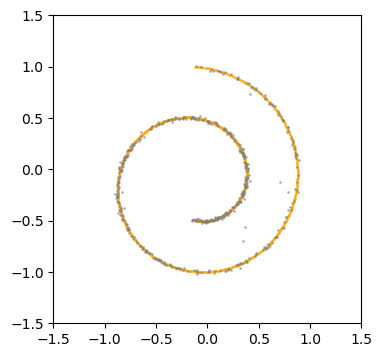

In [13]:
# plot the distribution of the generated samples
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(gt_manifold[:, 0], gt_manifold[:, 1], s=1, c='orange', alpha=0.5)
ax.scatter(seq_x[:, 0], seq_x[:, 1], s=1, c='grey', alpha=0.5)
ax.set(aspect='equal', xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])



(500, 101, 2)


Text(0.5, 1.0, 'Trajectory of $\\mathbf{x}_t$')

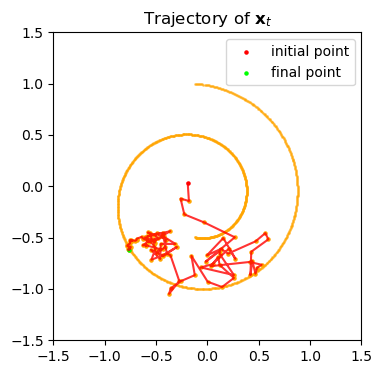

In [14]:
# plot plot the trajectory of the generated samples
print(seq_rev_x.shape)

sequence_num = 2

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(*gt_manifold.T, s=1, c='orange', alpha=0.5)
ax.scatter(*seq_rev_x[sequence_num, :].T, s=1, c='grey', alpha=0.5)


# plot all the samples of x_t
for t in range(num_steps, 0, -1):
    ax.scatter(*seq_rev_x[sequence_num,t].T, color='orange', s=5)

# plot the lines in between
ax.plot(*seq_rev_x[sequence_num, :].T, '-', color='red', alpha=0.8)

# plot the first and last points
ax.scatter(*seq_rev_x[sequence_num, 0].T, color='red', s=5, label="initial point")
ax.scatter(*seq_rev_x[sequence_num, 100].T, color='lime', s=5, label='final point')

# add figure details
ax.set_aspect('equal')
lims=[-1.5, 1.5]
ax.set(xlim=lims, ylim=lims)
ax.legend()
ax.set_title('Trajectory of $\mathbf{x}_t$')

In [17]:
# create the sequence of data samples to animate
init_seq_idx = 9
sequence = []
for i in range(10):
    fwd = seq_fwd_x[init_seq_idx+i]
    rev = seq_rev_x[init_seq_idx+i]
    sequence.append(fwd)
    sequence.append(rev)
sequence = np.array(sequence)
sequence = sequence.reshape(-1, 2)
print(sequence.shape)

(2020, 2)


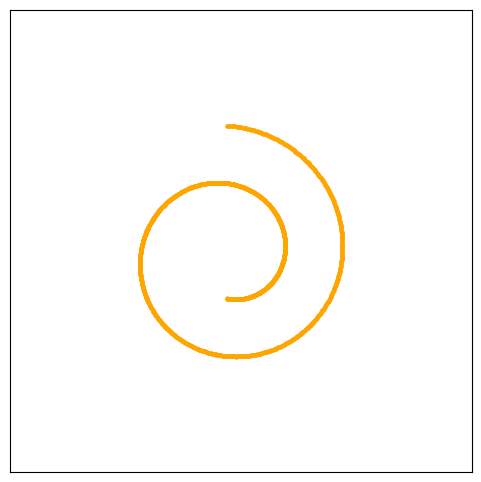

In [18]:
# create an animation
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*gt_manifold.T, s=5, c='orange', alpha=1)
ax.set(aspect='equal')

x_vals = []
y_vals = []
x_vals_line = []
y_vals_line = []
intensity = []
iterations = 100 #set number of frames for video
num_cycles = 5

# blues = [[0,0,1,0],[0,0,1,0.5],[0,0.2,0.4,1]]
# cmap = LinearSegmentedColormap.from_list("red", blues)
cmap = plt.get_cmap("Greys")
# cmap = plt.get_cmap('Reds')
scatter = ax.scatter(x_vals, y_vals, c=[], cmap=cmap, vmin=0, vmax=1, s=5)
line = ax.plot(x_vals, y_vals)[0]
line_list = []
max_length = 20

def update(frame):
    global x_vals, y_vals, intensity
    # Get intermediate points
    new_xvals = sequence[int(frame), 0]
    new_yvals = sequence[int(frame), 1]
    x_vals.append(new_xvals)
    y_vals.append(new_yvals)
    x_vals_line.append(new_xvals)
    y_vals_line.append(new_yvals)

    # Put new values in your plot
    scatter.set_offsets(np.c_[x_vals,y_vals])

    #calculate new color values
    intensity = np.concatenate((np.array(intensity)*0.96, np.ones(1)))
    scatter.set_array(intensity)
    
    # delete scatter samples that we don't anymore 
    if len(x_vals)>max_length:
        x_vals.pop(0)
        y_vals.pop(0)
        intensity = intensity[1:]
        scatter.set_offsets(np.c_[x_vals,y_vals])
        scatter.set_array(intensity)    
    
    
    # ------------------------------- line segment ------------------------------- #
    #if not the first line segment, change color to grey, 
    if not frame:
        line_list[:] = []   
    else:
        if frame // 100 % 2 == 0:
            line_list[-1].set_color("blue")
        else:
            line_list[-1].set_color("red")
        #then reduce gradually the alpha value for all line segments
        diff2max = max(0, max_length-len(line_list))
        [x.set_alpha((j+diff2max)/max_length) for j, x in enumerate(line_list)]
    
    #delete line segments that we don't see anymore to declutter the space
    if len(line_list)>max_length:
        del_line = line_list.pop(0)
        del_line.remove()  

    if frame // 100 % 2 == 0:
        newsegm, = ax.plot(x_vals_line[frame:frame+2], y_vals_line[frame:frame+2], "blue", lw=2)
    else:
        newsegm, = ax.plot(x_vals_line[frame:frame+2], y_vals_line[frame:frame+2], "red", lw=2) 
    line_list.append(newsegm)
    
    # Set title
    phase = (frame/100) % 2
    # ax.set_title(f'Phase: {phase:0.2f} $\pi$')

# lc = LineCollection(segments, cmap=cmap, norm=norm)

ani = animation.FuncAnimation(fig=fig, func=update, frames=num_cycles * 200, interval=50)
ax.set(xlim=[-2, 2], ylim=[-2, 2])
from utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)
plt.show()

from IPython.display import HTML
HTML(ani.to_html5_video())

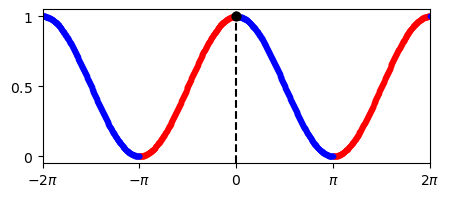

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 2))

# Generate data for the sinusoid
x = np.linspace(-2 * np.pi, 12 * np.pi, 14 * 200)  # Create an array of x values
y = np.sin(x+np.pi/2)  # Compute the corresponding y values

# Calculate the gradient of the curve
dy = np.gradient(y)
dx = x[1] - x[0]  # Assumes a constant x-spacing
gradient = dy / dx

# Find points with positive and negative gradients
positive_gradient_mask = gradient > 0
negative_gradient_mask = gradient < 0

# Create the scatter plot
scatter_red = ax.scatter(x[positive_gradient_mask], y[positive_gradient_mask], c='red', label='Positive Gradients', s=10)
scatter_blue = ax.scatter(x[negative_gradient_mask], y[negative_gradient_mask], c='blue', label='Negative Gradients', s=10)

# vertical black line at x=0
ax.axvline(x=0, color='black', linestyle='--')

# intersection point
intersection_x = [0]
intersection_y = [0]
intersection = ax.scatter(0, 1, c='black', label='Intersection Point', s=40)

ax.set(xlim=[-2 * np.pi, 2 * np.pi]) #, ylim=[-1.5, 1.5])

# Show the plot
from utils import remove_all_ticks_and_labels
# remove_all_ticks_and_labels(ax)
# plt.show()

# Function to update the scatter plot for animation
def update(frame):
    new_x = x - frame * (np.pi / 100)  # Move the data left
    scatter_red.set_offsets(np.column_stack((new_x[positive_gradient_mask], y[positive_gradient_mask])))
    scatter_blue.set_offsets(np.column_stack((new_x[negative_gradient_mask], y[negative_gradient_mask])))
    
    intersection_x[0] = 0
    intersection_y[0] = np.sin(frame * (np.pi / 100) + np.pi/2)
    intersection.set_offsets(np.column_stack((intersection_x, intersection_y)))
    
    return scatter_red, scatter_blue, intersection

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=1000, interval=50, repeat=True)

ax.set(xticks=[-2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi], xticklabels=['$-2\pi$', '$-\pi$', '$0$', '$\pi$', '$2\pi$'], yticks=[-1, 0, 1], yticklabels=['$0$', '$0.5$', '$1$'])

# Display the animation
plt.show()


from IPython.display import HTML
HTML(ani.to_html5_video())